<a href="https://colab.research.google.com/github/DuyDucNguyen/Practical_FEM_FEniCS_Colab/blob/master/error_indicator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Error Indicatior

In [0]:
# This program shows to compute error indicator for adaptive mesh refinement

# Reference: This program is followed the ideas in last chapter of the course 'edx.org - KTHx - High Performance Finite Element Modeling'. 
# The author modifies it up to date and give clear explaination.  

# Copyright (C) 2019 Duy Duc NGUYEN (duyduc.nguyen@protonmail.com)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2019-09-23
# Last changed: 2019-09-23

# This demo is maintained by Duy Duc NGUYEN
# Please report possible problems to duyduc.nguyen@protonmail.com

Install Fenics

In [0]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

!rm -rf * # clean up all files
# Useful commands
# Remove an empty folder      : os.rmdir("my_results")
# Remove a folder with files  : shutil.rmtree("results")
# Make a folder               : os.mkdir("my_results")
# Runtime/Change_runtime_type/Python3

**Primal problem:** (unknown is $u$) Consider the stationary
convection - diffusion - reaction problem in: 


\begin{equation}
-\epsilon\nabla^{2}u+\boldsymbol{\beta}\cdot\nabla u+\alpha u=f\text{ in }\Omega
\end{equation}


where $\Omega=\left[0,1\right]\times\left[0,1\right]$, vector field
$\boldsymbol{\beta}=\left(-5(y-0.5),5(x-0.5)\right)$, coefficients
$\alpha=0.1$, $\epsilon=0.01$ and the source 

\begin{equation}
f\left(x\right)=\left\{ \begin{array}{ccc}
1 & \text{ if } & |x-\left(0.75,0.75\right)|\leq0.1\\
0 &  & \text{otherwise}
\end{array}\right..
\end{equation}


Weak form $u\in V$

\begin{equation}
\int_{\Omega}\left(\epsilon\nabla u\nabla v+\boldsymbol{\beta}\cdot\nabla uv+\alpha uv\right)\ \mathrm{d}x=\int_{\Omega}fv\ \mathrm{d}x,\forall v\in V
\end{equation}

Bi-linear and linear form
\begin{align*}
a\left(u,v\right) & :=\int_{\Omega}\left(\epsilon\nabla u\nabla v+\boldsymbol{\beta}\cdot\nabla uv+\alpha uv\right)\ \mathrm{d}x\\
L\left(v\right) & :=\int_{\Omega}fv\ \mathrm{d}x
\end{align*}

Residual $r\left(u,v\right):=a\left(u,v\right)-L\left(v\right)=0$

**Goal function:**(Quantity of interest) Let $\mathcal{M}:V\to\mathbb{R}$
and
\begin{equation}
\mathcal{M}\left(u\right)=\int_{\Omega}u\left(x\right)\chi_{C(0.25,0.25,1)}\left(x\right)\ \mathrm{d}x
\end{equation}


**Adjoint problem:** (dual problem) from definition above
\begin{equation}
a\left(v,\phi\right)=\mathcal{M}\left(v\right),\forall v\in V
\end{equation}
or

\begin{equation}
\int_{\Omega}\left(\epsilon\nabla v\nabla\phi+\boldsymbol{\beta}\cdot\nabla v\phi+\alpha v\phi\right)\ \mathrm{d}x=\mathcal{M}\left(v\right)
\end{equation}


Apply Green rule
\begin{equation}
\int_{\Omega}\left(-\epsilon v\nabla^{2}\phi-\boldsymbol{\beta}\cdot\nabla\phi v+\alpha v\phi\right)\ \mathrm{d}x=\int_{\Omega}\left(-\epsilon\nabla^{2}\phi-\boldsymbol{\beta}\cdot\nabla\phi+\alpha\phi\right)v\ \mathrm{d}x=\int v\left(x\right)\chi_{C(0.25,0.25,1)}\left(x\right)\ \mathrm{d}x
\end{equation}


Strong form for dual problem
\begin{equation}
-\epsilon\nabla^{2}\phi-\boldsymbol{\beta}\cdot\nabla\phi+\alpha\phi=\psi\text{ in }\Omega
\end{equation}
with the source

\begin{equation}
\psi\left(x\right)=\chi_{C(0.25,0.25,1)}(x)=\left\{ \begin{array}{ccc}
1 & \text{ if } & |x-\left(0.25,0.25\right)|\leq0.1\\
0 &  & \text{otherwise}
\end{array}\right.
\end{equation}
weak form 
\begin{align*}
a^{*}\left(\phi,v\right) & :=\int_{\Omega}\epsilon\nabla\phi\nabla v-\boldsymbol{\beta}\cdot\nabla\phi v+\alpha\phi v\ \mathrm{d}x\\
L\left(v\right) & :=\int_{\Omega}\psi v\ \mathrm{d}x
\end{align*}

**Error Representation:** Prove that the error measured in the
goal is actually the residual of the dual solution. By definition
\begin{align*}
\mathcal{E} & =\mathcal{M}\left(u\right)-\mathcal{M}\left(u_{h}\right)\\
 & =\mathcal{M}\left(u-u_{h}\right)\\
 & =a\left(u-u_{h},\phi_h\right)=a\left(u,\phi_h\right)-a\left(u_{h},\phi_h\right)\text{ (from adjoint problem)}\\
 & =L\left(\phi_h\right)-a\left(u_{h},\phi_h\right)\text{ (from primal problem)}\\
 & =-r\left(u_{h},\phi_h\right)\text{ (definition of residual)}\\
\end{align*}


**Error indicator:** From the error representation above


\begin{equation}
  \mathcal{E}=-r\left(u_{h},\phi_h\right)=-\sum_{K\in T}r\left(u_{h},\phi_h\right){}_{K}
\end{equation}
where $K$ is a cell. The error indicator is defined by 
\begin{equation}
  \mathcal{E}_{K}=|r(u_{h},\phi_h)_{K}|
\end{equation}

**Strategy**: if $\mathcal{E}_{K}$ is large, refine $K$. Note
that $r(u_{h},\phi_{h})=0$ but $r(u_{h},\phi_{h})_{K}$ is not zero
and carries information about the local error contribution. 

**Adaptive algorithm:** 

1) Choose an initial triangulation $T_{h}^{0}$ as starting guess. 

2) Compute FEM solution $u_{h}$ on $T_{h}^{j}$

3) Evalute stopping criterion, either the error representation $|r(u_{h},\phi_{h})|\leq Tol$

if available, or the goal quantity from two successive adaptive iterations $|\mathcal{M}(u_{h}^{j})-\mathcal{M}(u_{h}^{j-1})|\leq Tol$


4) Refine a percentage of the cells $K$ where the error contribution/
indicator $\mathcal{E}_{K}=|r(u_{h},\phi_{h})_{K}|$ is largest, with
local mesh bisection (e.g. Rivara refinement for simplices). 

The following code solves the primal problem, the dual problem and
calculates the error indicators:


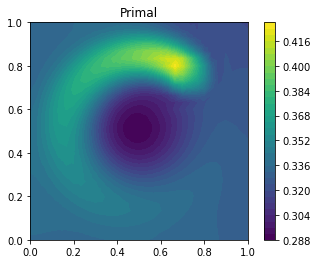

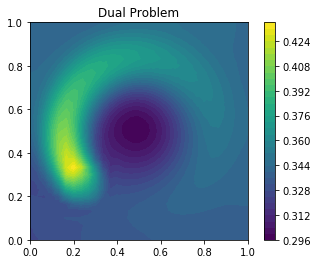

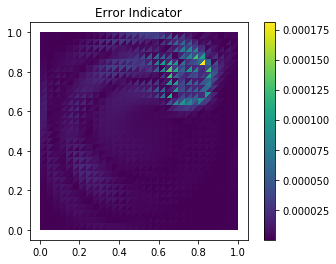

In [7]:
from mshr import *
import time
import matplotlib.pyplot as plt


# Create mesh
mesh = UnitSquareMesh(30,30)


# function sapce
Q = FunctionSpace(mesh, "CG", 1);


# trial and test functions
u = TrialFunction(Q);
v = TestFunction(Q);


# coefficients
alpha = 0.1
epsilon = 0.01
beta = Expression(("-5*(x[1] - 0.5)", "5*(x[0] - 0.5)"), degree=2)


# a and L
def aform(u,beta,v):
    return epsilon*inner(grad(u), grad(v)) + inner(beta, grad(u))*v + alpha*u*v

def Lform(f,v):
    return f*v



# primal problem
f = Expression("((x[0] - 0.75)*(x[0] - 0.75) + (x[1] - 0.75)*(x[1] - 0.75)) < 0.1*0.1 ? 1 : 0", degree=2)
a= aform(u, beta, v)*dx
L= Lform(f, v)*dx


# solve primal problem
wprimal = Function(Q);
solve(a==L, wprimal)


# dual problem
wdual = Function(Q);
psi = Expression("((x[0] - 0.25)*(x[0] - 0.25) + (x[1] - 0.25)*(x[1] - 0.25)) < 0.1*0.1 ? 1 : 0", degree=2)

a = aform(u, -beta, v)*dx
L = Lform(psi, v)*dx

solve(a==L, wdual)


# Compute Error Indicator
# Discontinuous Galerkin space
Z = FunctionSpace(mesh, "DG", 0); 
z = TestFunction(Z)
ei = Function(Z)

re = aform(wprimal, beta, wdual)*z*dx - Lform(f, wdual)*z*dx


ei.vector()[:] = assemble(re)[:]
ei.vector()[:] = abs( ei.vector()[:] )


# ======= Plot ======= 

plt.figure()
pp = plot(wprimal)
plt.title("Primal")
plt.colorbar(pp);

plt.figure()
qq = plot(wdual)
plt.title("Dual Problem")
plt.colorbar(qq);

plt.figure()
ee = plot(ei) 
plt.title("Error Indicator")
plt.colorbar(ee);



plt.show()



